In [ ]:
!pip install piml mapie

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from piml.diagnoser.reliability import ResidualConformalRegressor
from mapie.regression import MapieQuantileRegressor, MapieRegressor
from mapie.conformity_scores import ResidualNormalisedScore

def scp_naive(base_model, x_cal, y_cal, x_test, alpha=0.1):

    mapie_model = MapieRegressor(base_model, cv='prefit')
    mapie_model.fit(x_cal, y_cal)
    y_pred, y_pis = mapie_model.predict(x_test, alpha=alpha)
    lower = np.array(y_pis)[:, 0].ravel()
    upper = np.array(y_pis)[:, 1].ravel()
    return lower, upper

def scp_sigma(base_model, x_cal, y_cal, x_test, alpha=0.1, depth=5, random_state=0):

    x_res, x_cal, y_res, y_cal = train_test_split(x_cal, y_cal, test_size=1 / 3, random_state=random_state)
    y_sigma = np.abs(y_res.reshape(-1, 1) - base_model.predict(x_res).reshape(-1, 1))
    model_sigma = HistGradientBoostingRegressor(max_depth=depth, random_state=random_state)
    model_sigma.fit(x_res, y_sigma)
    mapie_model = MapieRegressor(base_model, cv='prefit',
                    conformity_score=ResidualNormalisedScore(prefit=True, residual_estimator=model_sigma))
    mapie_model.fit(x_cal, y_cal)
    y_pred, y_pis = mapie_model.predict(x_test, alpha=alpha)
    lower = np.array(y_pis)[:, 0].ravel()
    upper = np.array(y_pis)[:, 1].ravel()
    return lower, upper

def scp_crqr(base_model, x_cal, y_cal, x_test, alpha=0.1, depth=5, random_state=0):

    reliability = ResidualConformalRegressor(alpha=alpha, depth=depth, rand=random_state)
    reliability.fit(x_cal, y_cal, base_model.predict(x_cal.reshape(-1, 1)))
    lower, _, upper = reliability.predict(x_test, base_model.predict(x_test))
    return lower, upper

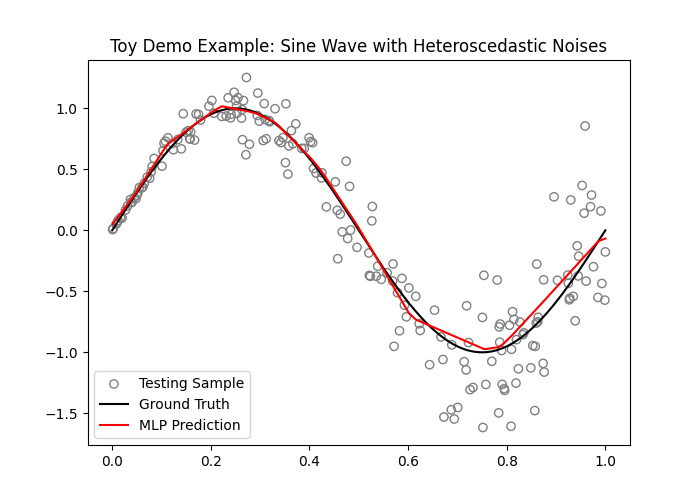

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

random_state = 0
np.random.seed(random_state)

n_samples = 1000
x = np.linspace(0, 1, n_samples)

y0 = np.array(np.sin(x * 2 * np.pi))
y = y0 + np.random.normal(0, 1, n_samples) * np.abs(x) * np.pi ** 2 / 20

# Train/Calibration/Test split
x_train, x_tmp, y_train, y_tmp = train_test_split(x, y, test_size=0.4, random_state=random_state)
x_cal, x_test, y_cal, y_test = train_test_split(x_tmp, y_tmp, test_size=0.5, random_state=random_state)

base_model = MLPRegressor(hidden_layer_sizes=(20, 20, 20, 20), activation="relu", max_iter=500, random_state=0)
base_model.fit(x_train.reshape(-1, 1), y_train)
y_test_pred = base_model.predict(x_test.reshape(-1, 1))

plt.figure(figsize=(7, 5))
plt.scatter(x_test, y_test, facecolors='none', edgecolors='grey')
plt.plot(x, y0, color='black')
x_sorted, y_sorted = zip(*sorted(zip(x_test, y_test_pred)))
plt.plot(x_sorted, y_sorted, color='red')
plt.title('Toy Demo Example: Sine Wave with Heteroscedastic Noises')
plt.legend(labels=["Testing Sample", "Ground Truth", "MLP Prediction"])
plt.show()

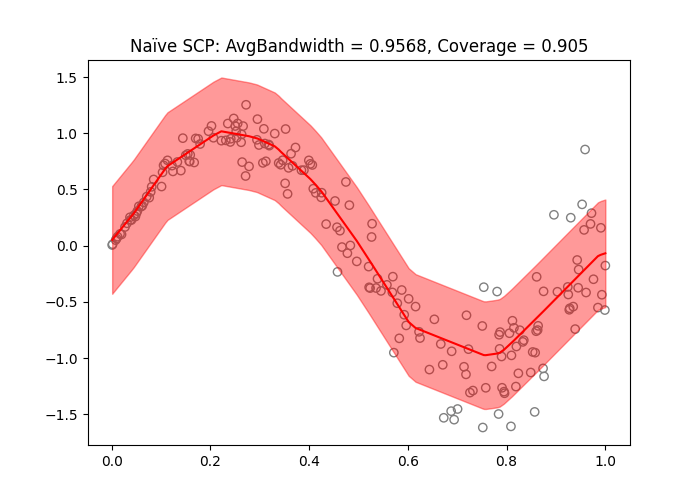

In [ ]:
lower, upper = scp_naive(base_model, x_cal.reshape(-1, 1), y_cal.reshape(-1, 1), x_test.reshape(-1, 1), alpha=0.1)
coverage = (upper - y_test >= 0) & (lower - y_test <= 0)

plt.figure(figsize=(7, 5))
plt.scatter(x_test, y_test, facecolors='none', edgecolors='grey')
order = np.argsort(x_test)
plt.plot(x_test[order], y_test_pred[order], color='red')
plt.fill_between(x_test[order], lower[order], upper[order], alpha=0.4, color="red")
plt.title("Naïve SCP: " + 'AvgBandwidth = {}'.format(np.round(np.mean(upper - lower), 4)) +
     ', Coverage = {}'.format(np.round(coverage.mean(), 3)))
plt.show()

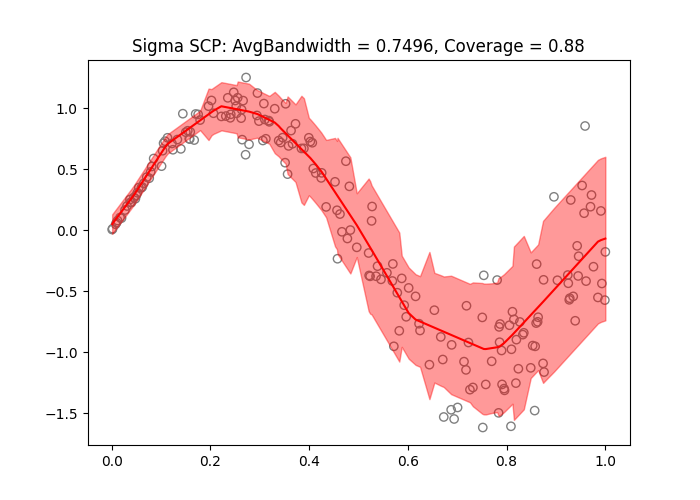

In [ ]:
lower, upper = scp_sigma(base_model, x_cal.reshape(-1, 1), y_cal.reshape(-1, 1), x_test.reshape(-1, 1), alpha=0.1)
coverage = (upper - y_test >= 0) & (lower - y_test <= 0)

plt.figure(figsize=(7, 5))
plt.scatter(x_test, y_test, facecolors='none', edgecolors='grey')
order = np.argsort(x_test)
plt.plot(x_test[order], y_test_pred[order], color='red')
plt.fill_between(x_test[order], lower[order], upper[order], alpha=0.4, color="red")
plt.title("Sigma SCP: " + 'AvgBandwidth = {}'.format(np.round(np.mean(upper - lower), 4)) +
     ', Coverage = {}'.format(np.round(coverage.mean(), 3)))
plt.show()

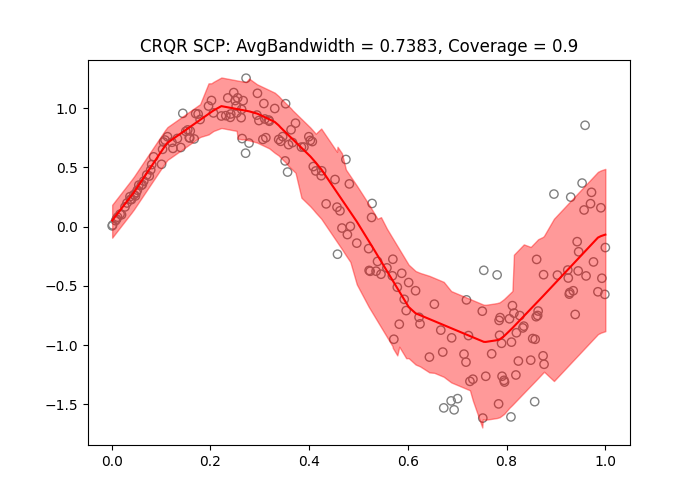

In [ ]:
lower, upper = scp_crqr(base_model, x_cal.reshape(-1, 1), y_cal.reshape(-1, 1), x_test.reshape(-1, 1), alpha=0.1)
coverage = (upper - y_test >= 0) & (lower - y_test <= 0)

plt.figure(figsize=(7, 5))
plt.scatter(x_test, y_test, facecolors='none', edgecolors='grey')
order = np.argsort(x_test)
plt.plot(x_test[order], y_test_pred[order], color='red')
plt.fill_between(x_test[order], lower[order], upper[order], alpha=0.4, color="red")
plt.title("CRQR SCP: " + 'AvgBandwidth = {}'.format(np.round(np.mean(upper - lower), 4)) +
     ', Coverage = {}'.format(np.round(coverage.mean(), 3)))
plt.show()